In [7]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from sim_tools.sim_baseline import sim_mpc
import sim_tools.dynamics as dynamics

state_bounds = np.array([np.pi/8, np.pi/8, np.pi/16, np.pi/16])

"""
Case 1: Angular deflection only, no initial momentum
"""

N_points = 4
sg = np.array([0., 0., 0., 0.])
q1 = np.linspace(-state_bounds[0], state_bounds[0], N_points)
q2 = np.linspace(-state_bounds[1], state_bounds[1], N_points)
q1_mesh, q2_mesh = np.meshgrid(q1, q2)
x0 = np.concatenate((q1_mesh.reshape((-1,1)), q2_mesh.reshape((-1,1)), np.zeros((N_points**2,1)), np.zeros((N_points**2,1))), axis=1)

errors = []
runtimes = []
#t = np.linspace(0,10,100)
t = np.linspace(0,5,50)
dt = t[1]-t[0]
Q = 1*np.eye(4)
R = 1*np.eye(2)
P = np.diag([1, 1, 1, 1])
N = 20
A,B = dynamics.linear_dynamics(dt)

for ic_id, ic_val in enumerate(x0):
    state_hist, control_hist, runtime = sim_mpc(t, ic_val, sg, Q, R, P, N)
    errors.append(sg-state_hist[-1])
    runtimes.append(runtime)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
rms_errors = np.sqrt(np.sum(np.array(errors)**2, axis=1))
print(rms_errors.shape)

(16,)


<function matplotlib.pyplot.show(close=None, block=None)>

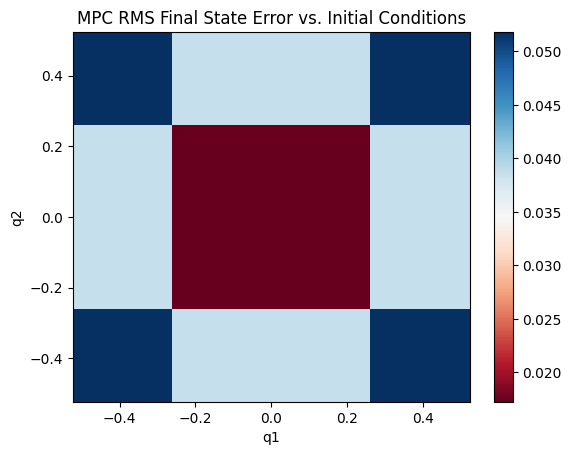

In [30]:
fig, ax = plt.subplots()
c = ax.pcolormesh(q1_mesh, q2_mesh, rms_errors.reshape((N_points,N_points)), cmap="RdBu")
fig.colorbar(c, ax=ax)
ax.set_xlabel("q1")
ax.set_ylabel("q2")
ax.set_title("MPC RMS Final State Error vs. Initial Conditions")
plt.show

In [36]:
import torch
from sim_tools.sim_neural import sim_neural 
from neural import neural_energy as enn
import torch.nn as nn

errors_neural = []
x0_torch = torch.Tensor(x0)
sg_torch = torch.Tensor(sg)
t_torch = torch.Tensor(t)
a,b = x0_torch.shape

hdim = 256 #126 256
V = nn.Sequential(
    nn.Linear(2, hdim),
    nn.ReLU(),
    nn.Linear(hdim, hdim),
    nn.ReLU(),
    nn.Linear(hdim, hdim),
    nn.ReLU(),
    nn.Linear(hdim, hdim),
    nn.ReLU(),
    nn.Linear(hdim, hdim),
    nn.Tanh(),
    nn.Linear(hdim,2)
)
K = nn.Sequential(
    nn.Linear(4, hdim),
    nn.ReLU(),
    nn.Linear(hdim, hdim),
    nn.ReLU(),
    nn.Linear(hdim, hdim),
    nn.ReLU(),
    nn.Linear(hdim, hdim),
    nn.ReLU(),
    nn.Linear(hdim,2),
    nn.ReLU()
)

f = enn.MirrorSystem(V,K)
model = enn.AugmentedMirror(f, enn.ControlEffort(f)).cpu()

global device
device = 'cpu'
model.load_state_dict(torch.load("models/deep.pth"))
model.eval().cpu()
trajs, _, runtime_torch = sim_neural(model, x0_torch, sg_torch, t_torch)



In [37]:
errors_torch = np.array(trajs)[-1,:,:] - sg
rms_errors_torch = np.sqrt(np.sum(errors_torch**2, axis=1))


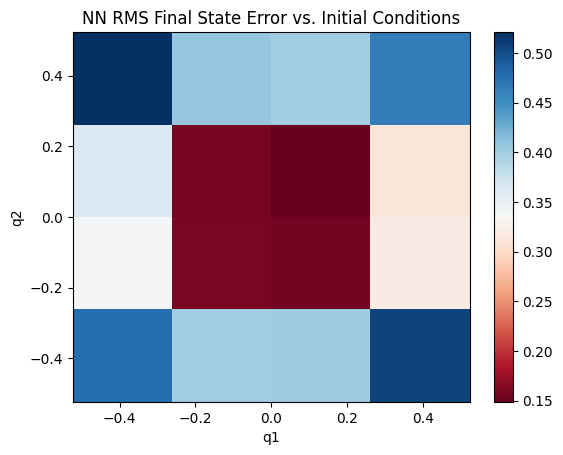

In [38]:
fig, ax = plt.subplots()
c = ax.pcolormesh(q1_mesh, q2_mesh, rms_errors_torch.reshape((N_points,N_points)), cmap="RdBu")
fig.colorbar(c, ax=ax)
ax.set_xlabel("q1")
ax.set_ylabel("q2")
ax.set_title("NN RMS Final State Error vs. Initial Conditions")
plt.show()